## Does our likelihood model capture the mean/variance of imagery responses conditioned on value of the visual response? 

In [34]:
from imagery_psychophysics.src.variational import *
from imagery_psychophysics.utils.variational_utils import open_imagery_probe_data
from imagery_psychophysics.src.stirling_maps import stirling_num_of_2nd_kind as snk
from imagery_psychophysics.src.stirling_maps import stirling_partitions
from imagery_psychophysics.src.model_z import noise_grid
from skimage.morphology import binary_dilation, binary_erosion
from itertools import product
from scipy.stats import linregress

import seaborn as sns
import numpy as np
import pandas as pd
import math
import copy

from scipy.stats import sem
from scipy.stats import pearsonr

from matplotlib import pyplot as plt
from os.path import join
from PIL.Image import open as open_image
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [30]:
def score(K, response,c,p_on,p_off):
    '''
    calculates p(response | object_count, p_on, p_off), the strange likelihood I derived for this model

    score(K, response,object_count,p_on,p_off)
    inputs:
        K ~ largest number of objects possible
        response ~ integer
        object_count ~ integer
        p_on,p_off ~ noise params
    outputs:
        scalar likelihood value. 
    '''

    ##
    try:
        counts = np.array([nCk(c,m)*nCk(K-c, response-m) for m in range(min(response,c)+1)])
        probs = np.array([(1-p_on)**(c-m) * (p_on)**m * (p_off)**(response-m) * (1-p_off)**(K-c-response+m) for m in range(min(response,c)+1)])
        return counts.dot(probs)
    except TypeError:
        print 'Error in score. response and count should be integer-valued.'
        print response
        print c
        print min(response,c)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.


Text(0.5,1,u' = 5')

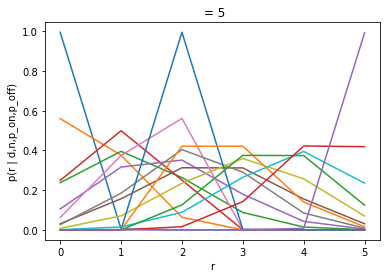

In [41]:
##this is a very flexible distribution
K = 5
conditioning_count = 2
p_on, p_off = noise_grid(5,5)
for p in zip(p_on,p_off):
    probs = [score(K,r,conditioning_count, p[0],p[1]) for r in range(K+1)]
    ##sanity check
    if np.abs(np.sum(probs)-1) > .00000000000001:
        print 'uh-oh'
        print np.sum(probs)
    plt.plot(range(K+1), probs,label = '(%0.2f, %0.2f)' %(p))

#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, fancybox=True, prop = {'size': 8})

plt.xlabel('r')
plt.ylabel('p(r | d,n,p_on,p_off)')
plt.title(' = %d' %(K))

In [35]:
noise_grid(10,10)

([0.001,
  0.11188888888888888,
  0.11188888888888888,
  0.22277777777777777,
  0.22277777777777777,
  0.22277777777777777,
  0.33366666666666667,
  0.33366666666666667,
  0.33366666666666667,
  0.33366666666666667,
  0.44455555555555554,
  0.44455555555555554,
  0.44455555555555554,
  0.44455555555555554,
  0.44455555555555554,
  0.5554444444444444,
  0.5554444444444444,
  0.5554444444444444,
  0.5554444444444444,
  0.5554444444444444,
  0.5554444444444444,
  0.6663333333333333,
  0.6663333333333333,
  0.6663333333333333,
  0.6663333333333333,
  0.6663333333333333,
  0.6663333333333333,
  0.6663333333333333,
  0.7772222222222221,
  0.7772222222222221,
  0.7772222222222221,
  0.7772222222222221,
  0.7772222222222221,
  0.7772222222222221,
  0.7772222222222221,
  0.7772222222222221,
  0.8881111111111111,
  0.8881111111111111,
  0.8881111111111111,
  0.8881111111111111,
  0.8881111111111111,
  0.8881111111111111,
  0.8881111111111111,
  0.8881111111111111,
  0.8881111111111111,
  0.999,


In [2]:
##read data using pre-made function that knows where data is
resultsDict = dict()
experiment_df = open_imagery_probe_data().dropna(axis=0)

In [7]:
##see it
experiment_df.tail()

,image,image_on,probe,resp_on,response,state,subj
8275,grape_juice_02,10154.8480,29_30,10156.5814,3.0,pcp,KL
8276,grape_juice_02,10156.7147,32_41_42,10159.8815,4.0,pcp,KL
8277,grape_juice_02,10159.9647,11,10161.1981,1.0,pcp,KL
8278,grape_juice_02,10161.3147,40_32_41,10166.2149,4.0,pcp,KL
8279,grape_juice_02,10166.2981,5_14_6,10168.1982,3.0,pcp,KL


In [10]:
##reformat so that the imagery and vision response are in separate columns
resp_table = experiment_df[['image', 'probe', 'response', 'state', 'subj']]
img_resp = resp_table[resp_table['state']=='img'].drop(columns=['state'])
pcp_resp = resp_table[resp_table['state']=='pcp'].drop(columns=['state'])
resp_table = img_resp.merge(pcp_resp,how='left', on = ['image', 'probe', 'subj'], suffixes = ('_img', '_vis'))
resp_table = resp_table[['subj','image','probe', 'response_vis', 'response_img']]

In [11]:
resp_table.head()

,subj,image,probe,response_vis,response_img
0,gsy,candle_01,10,1.0,1.0
1,gsy,candle_01,11,1.0,1.0
2,gsy,candle_01,0_1_10,1.0,1.0
3,gsy,candle_01,34_43_35_44,2.0,2.0
4,gsy,candle_01,29_38_30,3.0,2.0


In [13]:
##for each subject, each target, find best likelihood params that fit all data.
for nm,grp in resp_table.groupby(by=['subj', 'image', 'response_vis']):
    vis_resp = nm[2]
    img_responses = grp.response_img.values
    
    

(array([2., 0., 0., 2., 0., 0., 0., 0., 0., 1.]),
 array([4. , 4.3, 4.6, 4.9, 5.2, 5.5, 5.8, 6.1, 6.4, 6.7, 7. ]),
 <a list of 10 Patch objects>)

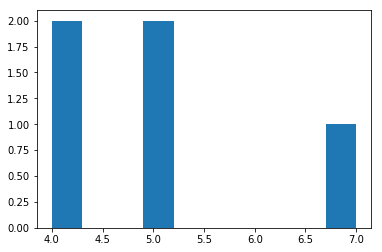

In [15]:
plt.hist(img_responses)